In [42]:
import sys
sys.path.insert(0,'C:\\users\\alexa\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize
import matplotlib.ticker as ticker

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple

"""
Own packages
"""

from codelib.statistics import calculate_cornish_fisher_percentile
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std
from codelib.portfolio_optimization.risk_metrics import calculate_normal_cond_value_at_risk, calculate_normal_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_normal_port_cond_value_at_risk, calculate_normal_port_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_conditional_value_at_risk, calculate_value_at_risk
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar
from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_normal_var, calculate_marginal_sharpe
from codelib.visualization.base import risk_waterfall_chart
from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
"""
Question 2
"""

# Covariance Matrix

vols = np.array([0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094])
corr_mat = np.array([[1.0, 0.6, 0.1, 0.3, -0.1, -0.1, -0.2, -0.1, -0.1, -0.1],
                     [0.6, 1.0, 0.6, 0.6, 0.2, 0.2, 0.2, 0.1, 0.1, 0.3],
                     [0.1, 0.6, 1.0, 0.7, 0.7, 0.6, 0.6, 0.4, 0.3, 0.7],
                     [0.3, 0.6, 0.7, 1.0, 0.5, 0.6, 0.4, 0.2, 0.2, 0.5],
                     [-0.1, 0.2, 0.7, 0.5, 1.0, 0.7, 0.8, 0.4, 0.4, 0.8],
                     [-0.1, 0.2, 0.6, 0.6, 0.7, 1.0, 0.7, 0.4, 0.4, 0.7],
                     [-0.2, 0.2, 0.6, 0.4, 0.8, 0.7, 1.0, 0.4, 0.4, 0.7],
                     [-0.1, 0.1, 0.4, 0.2, 0.4, 0.4, 0.4, 1.0, 0.3, 0.4],
                     [-0.1, 0.1, 0.3, 0.2, 0.4, 0.4, 0.4, 0.3, 1.0, 0.4],
                     [-0.1, 0.3, 0.7, 0.5, 0.8, 0.7, 0.7, 0.4, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

array([[ 0.001369 ,  0.001221 ,  0.0004403,  0.0011877, -0.0005661,
        -0.0008029, -0.0015096, -0.000518 , -0.0003996, -0.0003478],
       [ 0.001221 ,  0.003025 ,  0.003927 ,  0.003531 ,  0.001683 ,
         0.002387 ,  0.002244 ,  0.00077  ,  0.000594 ,  0.001551 ],
       [ 0.0004403,  0.003927 ,  0.014161 ,  0.0089131,  0.0127449,
         0.0154938,  0.0145656,  0.006664 ,  0.0038556,  0.0078302],
       [ 0.0011877,  0.003531 ,  0.0089131,  0.011449 ,  0.0081855,
         0.0139314,  0.0087312,  0.002996 ,  0.0023112,  0.005029 ],
       [-0.0005661,  0.001683 ,  0.0127449,  0.0081855,  0.023409 ,
         0.0232407,  0.0249696,  0.008568 ,  0.0066096,  0.0115056],
       [-0.0008029,  0.002387 ,  0.0154938,  0.0139314,  0.0232407,
         0.047089 ,  0.0309876,  0.012152 ,  0.0093744,  0.0142786],
       [-0.0015096,  0.002244 ,  0.0145656,  0.0087312,  0.0249696,
         0.0309876,  0.041616 ,  0.011424 ,  0.0088128,  0.0134232],
       [-0.000518 ,  0.00077  ,  0.006664

In [44]:
# Mean

mu = np.array([0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038])-0.5*np.diag(cov_mat)

In [45]:
# Defining a Function that Simulates Asset Prices

def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [46]:
# Simulate Asset Prices

num_sim = 5000
dt = 1.0
horizon = 5.0
mu = mu
cov_mat = cov_mat

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)

In [47]:
# Isolating Simulated Prices In Year 5 For Each Asset

asset_0 = asset_prices[:,5:6,:1]
asset_1 = asset_prices[:,5:6,:1]
asset_2 = asset_prices[:,5:6,1:2]
asset_3 = asset_prices[:,5:6,2:3]
asset_4 = asset_prices[:,5:6,3:4]
asset_5 = asset_prices[:,5:6,4:5]
asset_6 = asset_prices[:,5:6,5:6]
asset_7 = asset_prices[:,5:6,6:7]
asset_8 = asset_prices[:,5:6,7:8]
asset_9 = asset_prices[:,5:6,8:9]
asset_10 = asset_prices[:,5:6,9:10]

A0 = asset_0[:,0,0]
A1 = asset_1[:,0,0]
A2 = asset_2[:,0,0]
A3 = asset_3[:,0,0]
A4 = asset_4[:,0,0]
a5 = asset_5[:,0,0]
a6 = asset_6[:,0,0]
a7 = asset_7[:,0,0]
a8 = asset_8[:,0,0]
a9 = asset_9[:,0,0]
a10 = asset_10[:,0,0]

price_distribution = [A0, A1,A2,A3,A4,a5,a6,a7,a8,a9,a10]

Text(0, 0.5, 'Prices')

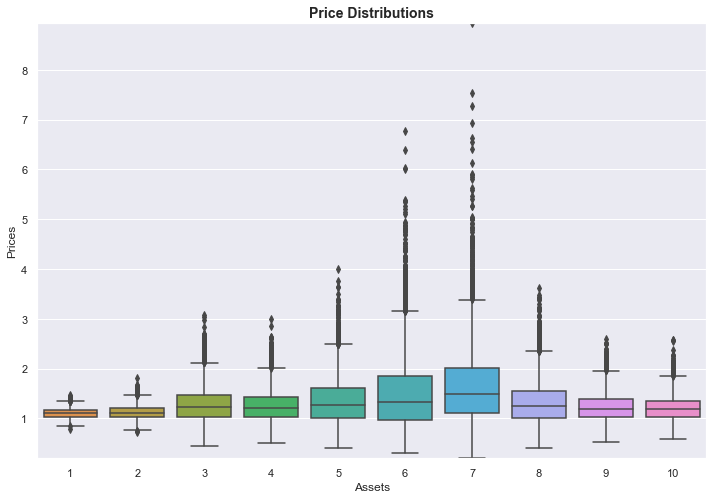

In [48]:
# Plotting the Price Distribution of Each Asset In Year 5

sns.set(rc={'figure.figsize':(12,8)})
ax = sns.boxplot(data=price_distribution)
ax.set_xlim(0.5,10.5)
ax.set_title('Price Distributions', fontsize=14, fontweight='bold')
ax.set_xlabel('Assets')
ax.set_ylabel('Prices')

In [49]:
# Expected Value of Portfolio in Year 5

""" Starting Value of Each Asset Holding """

a0 = 500000

""" Expected Value """

E_a1 = np.mean(asset_1)*a0
E_a2 = np.mean(asset_2)*a0
E_a3 = np.mean(asset_3)*a0
E_a4 = np.mean(asset_4)*a0
E_a5 = np.mean(asset_5)*a0
E_a6 = np.mean(asset_6)*a0
E_a7 = np.mean(asset_7)*a0
E_a8 = np.mean(asset_8)*a0
E_a9 = np.mean(asset_9)*a0
E_a10 = np.mean(asset_10)*a0

expected_portfolio_value = [E_a1,E_a2,E_a3,E_a4,E_a5,E_a6,E_a7,E_a8,E_a9,E_a10]
sum(expected_portfolio_value)

6498462.303796251

In [50]:
# Expected Value of Assets in Year 5

expected_portfolio_value = [E_a1,E_a2,E_a3,E_a4,E_a5,E_a6,E_a7,E_a8,E_a9,E_a10]
expected_asset_value = pd.DataFrame(expected_portfolio_value)
expected_asset_value

,0
0,550040.917710
1,558683.345431
2,639149.416536
3,621704.656852
4,673084.540604
5,752410.690993
6,830659.288303
7,656814.641683
8,612445.778004
9,603469.027680


In [51]:
# Expected Covariance in 5 years

asset_prices_y5 = np.stack((A1,A2,A3,A4,a5,a6,a7,a8,a9,a10), axis=1)
asset_names = ['1','2','3','4','5','6','7','8','9','10']
asset_prices_y5_named = pd.DataFrame(asset_prices_y5, columns=asset_names)
asset_prices_y5_named

asset_prices_y5_cov_mat = np.cov(asset_prices_y5_named.values.T)
asset_prices_y5_cov_mat

array([[ 0.00834515,  0.00773093,  0.00352739,  0.00860978, -0.00363997,
        -0.00651007, -0.01286213, -0.0031054 , -0.00199341, -0.00199559],
       [ 0.00773093,  0.01896641,  0.02799606,  0.02494661,  0.01278147,
         0.01844675,  0.02175705,  0.00523145,  0.00433601,  0.01032978],
       [ 0.00352739,  0.02799606,  0.11705254,  0.07197333,  0.10729829,
         0.14629758,  0.15386199,  0.05505087,  0.02863524,  0.05984539],
       [ 0.00860978,  0.02494661,  0.07197333,  0.09221734,  0.06789002,
         0.13078076,  0.08922144,  0.02463161,  0.01711576,  0.0380407 ],
       [-0.00363997,  0.01278147,  0.10729829,  0.06789002,  0.21248601,
         0.23920985,  0.28493445,  0.07893145,  0.05151793,  0.09350079],
       [-0.00651007,  0.01844675,  0.14629758,  0.13078076,  0.23920985,
         0.58327375,  0.40845555,  0.12110035,  0.08314913,  0.13231036],
       [-0.01286213,  0.02175705,  0.15386199,  0.08922144,  0.28493445,
         0.40845555,  0.6335195 ,  0.13106262

In [52]:
asset_wealth_y5 = asset_prices_y5*a0

Text(0, 0.5, 'Wealth (mio. Eur)')

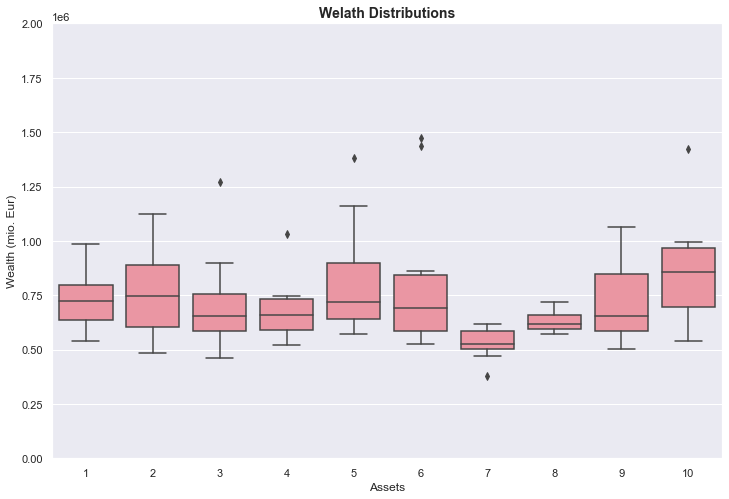

In [71]:
# Define The Expected Distribution of Wealth in 5 Years

w_a1 = A1*a0
w_a2 = A2*a0
w_a3 = A3*a0
w_a4 = A4*a0
w_a5 = a5*a0
w_a6 = a6*a0
w_a7 = a7*a0
w_a8 = a8*a0
w_a9 = a9*a0
w_a10 = a10*a0

wealth_dist = np.stack((w_a1,w_a2,w_a3,w_a4,w_a5,w_a6,w_a7,w_a8,w_a9,w_a10), axis = 0)

sns.set(rc={'figure.figsize':(12,8)})
ax = sns.boxplot(data=wealth_dist)
ax.set_xlim(0.5,10.5)
ax.set_ylim(0,2000000)
ax.set_title('Welath Distributions', fontsize=14, fontweight='bold')
ax.set_xlabel('Assets')
ax.set_ylabel('Wealth (mio. Eur)')

In [54]:
# Buy and hold strategy for equally weighted portfolio

port_w = np.ones(10) / 10

buy_and_hold_index = asset_prices @ port_w
buy_and_hold_index_total = buy_and_hold_index * a0
buy_and_hold_index_total.shape

(5000, 6)

In [55]:
# Buy and hold strategy for equally weighted portfolio

port_w = np.ones(10) / 10

buy_and_hold_index = asset_prices @ port_w
buy_and_hold_index_total = buy_and_hold_index * a0
buy_and_hold_index_total.shape

(5000, 6)

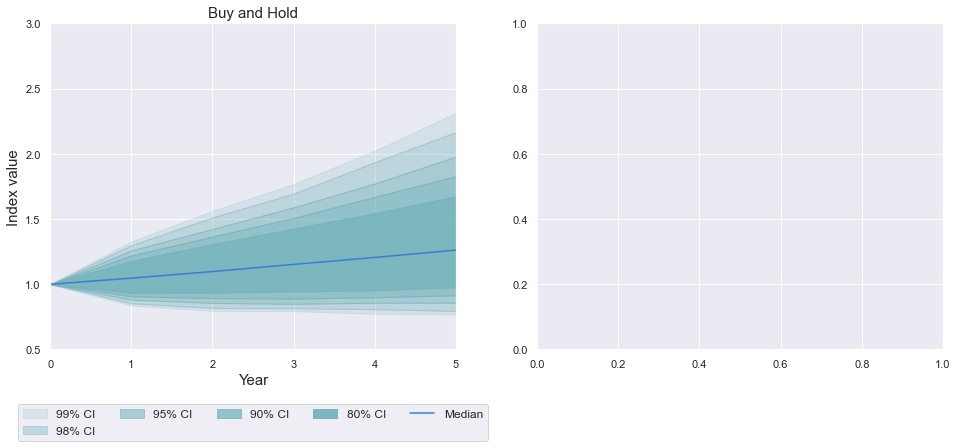

In [56]:
# calculate percentiles

percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)
"""
Plot fan chart
"""

fig, ax = plt.subplots(1,2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

In [57]:
# Starting Wealth

a0 = 500000

In [58]:
# Defining array of prices of all simulations each year for asset 5

a5_y0 = asset_prices[:,0:1,4:5]
a5_y1 = asset_prices[:,1:2,4:5]
a5_y2 = asset_prices[:,2:3,4:5]
a5_y3 = asset_prices[:,3:4,4:5]
a5_y4 = asset_prices[:,4:5,4:5]
a5_y5 = asset_prices[:,5:6,4:5]

a5_y0_mean = np.mean(a5_y0)
a5_y1_mean = np.mean(a5_y1)
a5_y2_mean = np.mean(a5_y2)
a5_y3_mean = np.mean(a5_y3)
a5_y4_mean = np.mean(a5_y4)
a5_y5_mean = np.mean(a5_y5)

# Transactions Cost

k = 0.02

In [59]:
# Defining The Total Cost Each Year Given The Absolut Return

a5_y0_cost = (a5_y0_mean*a0-a0)*k
a5_y1_cost = (a5_y1_mean*a0-a0)*k
a5_y2_cost = (a5_y2_mean*a0-a0)*k
a5_y3_cost = (a5_y3_mean*a0-a0)*k
a5_y4_cost = (a5_y4_mean*a0-a0)*k
a5_y5_cost = (a5_y5_mean*a0-a0)*k

Text(0.5, 1.0, 'Transactions Costs as a Function of Returns')

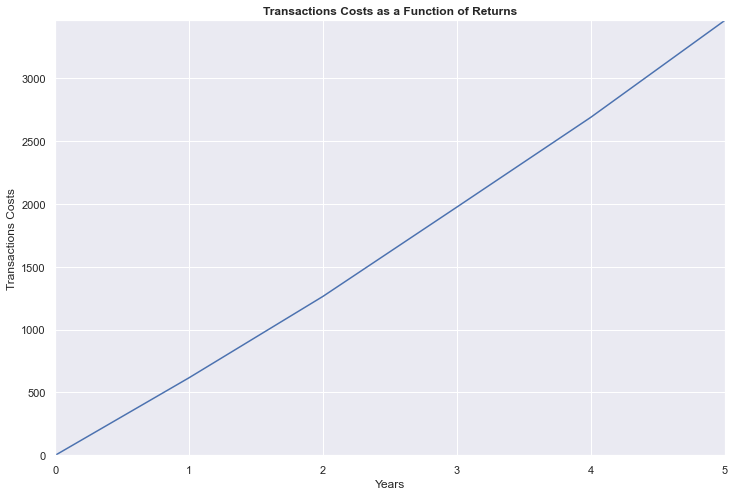

In [60]:
# Plotting The Linear Function of Transactions Costs

x = [0,1,2,3,4,5]
y = [a5_y0_cost,a5_y1_cost,a5_y2_cost,a5_y3_cost,a5_y4_cost,a5_y5_cost]

plt.plot(x,y)
plt.xlabel('Years')
plt.ylabel('Transactions Costs')
plt.title('Transactions Costs as a Function of Returns', fontweight='bold')

In [61]:
# Presentation of Portfolio Return Data

col_names = ['Year 0','Year 1','Year 2','Year 3','Year 4','Year 5']
buy_and_hold_index_table = pd.DataFrame(buy_and_hold_index, columns=col_names)
buy_and_hold_index_table

,Year 0,Year 1,Year 2,Year 3,Year 4,Year 5
0,1.0,1.093801,0.979147,0.952469,0.970635,0.998524
1,1.0,1.060510,1.021442,1.293865,1.333823,1.453760
2,1.0,0.979718,1.221468,1.220097,1.358884,1.527825
3,1.0,1.122863,1.187606,1.395237,1.503281,1.431385
4,1.0,0.938550,1.081338,1.309305,1.320711,1.366731
...,...,...,...,...,...,...
4995,1.0,1.231467,1.303156,1.362739,1.388810,1.315754
4996,1.0,1.137914,1.253695,1.090451,1.100715,1.185477
4997,1.0,1.069783,1.065758,0.948864,0.966038,0.979798
4998,1.0,1.178417,1.303860,1.592059,1.681294,1.999801


In [62]:
# Define Optimal Portfolio Weights

buy_and_hold_index_table
prices_5y = asset_prices[:,5]
cov_mat_5y = np.cov(prices_5y, rowvar=False)

"""
Define relevant constraints
"""
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * 10

target_returns = np.arange(1.2, 1.3, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

"""
Find optimal weights
"""

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(prices_5y @ x) - target_return}


    x0 = np.ones(10) / 10.0
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_5y,),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x)
    
optimal_weights = np.array(optimal_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01808516985554639
            Iterations: 20
            Function evaluations: 220
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01954558555782738
            Iterations: 19
            Function evaluations: 210
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.021094339498891945
            Iterations: 18
            Function evaluations: 198
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02273143035636257
            Iterations: 19
            Function evaluations: 209
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02445685938080781
            Iterations: 19
            Fu

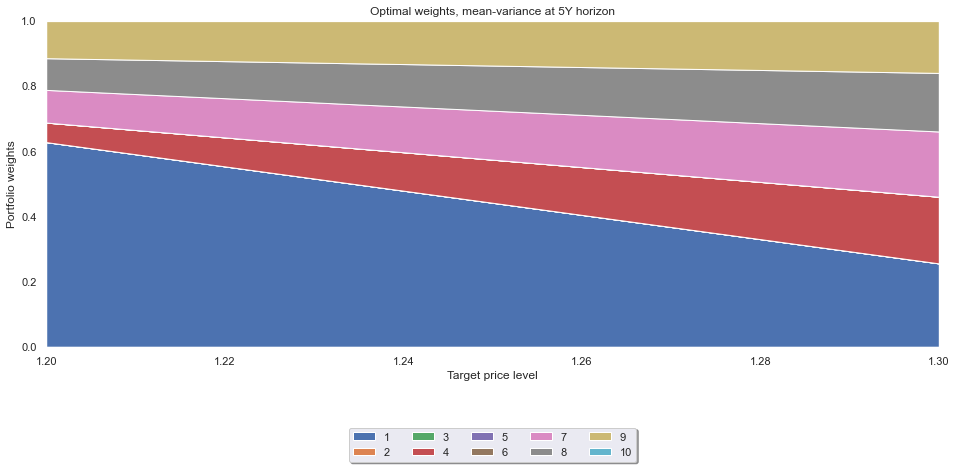

In [63]:
# Plotting The Optimal Weights Using Mean-Variance

fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(target_returns, optimal_weights.T, labels=np.arange(1,11));
ax.set_xlabel("Target price level")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, mean-variance at 5Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5);

In [64]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

'percentiles_constant_mix = np.percentile(constant_mix_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         'axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

'fan_chart(time_points,
          'percentiles_constant_mix,
          'color=default_colors['red'],
          'color_median=default_colors['dark_blue'],
          'labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          'ax=ax[1])

'ax[1].set_xlabel("Year", size=15)
'ax[1].set_title("Constant Mix", size=15)
'ax[1].set_ylim([0.5, 3.0])
'ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

SyntaxError: EOL while scanning string literal (991909541.py, line 5)

In [ ]:
# calculate percentiles

percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

percentiles_constant_mix = np.percentile(constant_mix_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

fan_chart(time_points,
          percentiles_constant_mix,
          color=default_colors['red'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[1])

ax[1].set_xlabel("Year", size=15)
ax[1].set_title("Constant Mix", size=15)
ax[1].set_ylim([0.5, 3.0])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

In [ ]:
# Defining Quadratic Utility Function 

def quadratic_utility(wealth: int) :
    
    """
    Function that returns the quadratic utility of a given allocation
    
    Parameters
    ----------
    weights: 
        Portfolio weights
    mu: 
        Expected returns
    cov_matrix: 
        Covariance matrix
    risk_aversion: 
        Risk aversion parameter
    
    Returns
    -------
    float
        Utility
    """
    return (wealth**gamma)/gamma